![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# Reinforcement Learning
# Assignment 3
## Introduction
Welcome to the third RL assignment.  Last week, we've dived in to Model-Free Prediction & Control with Temporal Difference (TD) and Q-Learning.
You've implemented an example of Off-Policy TD Control (SARSA) and another of On-policy TD Control (Q-Learning). <br/> 
For that, we have represented the value function by a lookup table. <br/>
But this approach has a problem: When the underlying Markov decision process is large there are too many states and actions to store in memory. It is extremely difficult to visit all the possible states, meaning that we cannot estimate the values for those states. <br/>

For this assignment, we are going to work with generalization: how to produce a good approximation of a large state space experiencing only a small subset, to illustrated how we can apply supervised learning instead of a lokkup table.

You will implement a linear version of the TD(0) algorithm and use it to find the utilities, by building a linear function approximation and also applying a Feature Construction for Linear Methods for multiple gridworlds.
You also will deal with a non-linear separable problem and learn how to overcome it

## Resources
I've always found experience the best teacher, so I advocate just diving in and trying to implement things.  However, it is always good to have other sources to reference, so every week I'll place links to things that I think are helpful to learn the material.
* [Chapter 9 of this book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) about On-policy Prediction and Approximation is nice.

### The Approximation
Our brain is a powerful approximator. <br/>
We can consider the world as a huge and chaotic state-space, where the correct evaluation of a specific stimulus makes the difference between life and death. <br/>
The brain stores information about the environment and allows an effective interaction with it. <br/>
Let's suppose that our brain is a massive **lookup table**, which can store in a single neuron (or cell) a single state. This is known as **local representation**. <br/>
It describes a hypothetical neuron that responds only to a specific and meaningful stimulus. There is an alternative hypothesis where we can suppose that information is stored in a distributed way, and that each single concept is represented through a pattern of activity. <br/>
To understand the difference between the two representations think about a computer keyboard.<br/>
In the local representation each single key can codify only a single character. In the distributed representation we can use a combination of keys (e.g. Shift and Ctrl) to associate multiple characters to the same key.

From a machine learning perspective, we know that the distributed representation works. The success of deep learning is based on neural networks, which are powerful function approximators. <br/>
Moreover, different methods, such as dropout, are tightly related to the distributed representation theory. Now it’s time to go back to reinforcement learning, and see how a distributed representation can solve the problems due to local representation.

### Function Approximation Intuition
In this assignment, you will use the **robot cleaning example**.<br/>
The robot moves in a two-dimensional gridworld: 
 + It has only 4 possible actions available (**forward, backward, left, right**) 
 + Its goal is to reach a charger (green cell) and avoid to fall on stairs (red cell). 

Let's consider: 
+ V(s) our usual value function 
+ Q(s,a) the state-action function. 

The grid-world is a discrete rectangular state space, having c columns and r rows. 

Using a tabular approach, we can represent V(s) using a table containing r x c = N elements, where:
+ N represents the total number of states. 

To represent Q(s,a) we need a table of size N x M, where:
+ M is the total number of actions. 

Our value function is a matrix having the same size of the world, whereas for the state-action function we use a matrix having N columns (states) and M rows (actions). <br/>
+ In the first case, to get the value we have to access the location of the matrix corresponding to the particular state where we are. 
+ In the second case, we use the state as index to access the column in the state-action matrix and from that column we return the values of all the available actions.
<img src="../images/val_aprox_1.png" alt="Drawing" style="width: 500px;"/>

**Note**: The value function is an abstract formulation of utility. That is why in some of the figures you see the term "utility" being used.

It is helpful to visualize a function approximator as a black box.<br/>
The method described below can be used on different approximators and for this reason we can easily apply it to the box content. <br/>
The black box takes as input the current state and returns the value of the state or the state-action values. <br/>
The main advantage is that we can approximate (with an arbitrary small error) the values using less parameters in respect to the tabular approach. <br/>
We can say that the number of elements stored in the vector w is smaller than N, the number of values in the tabular counterpart.

<img src="../images/val_aprox_2.png" alt="Drawing" style="width: 500px;"/>

In the case of a black box that is approximating a value function, the content of the box is the **Value Function Approximator $\hat{v}$(s,w)**. 

Using a more formal view we can say that the vector w is adjusted at every iteration, moving the values of a quantity Δ, in order to reach an objective which is minimizing a function of cost. <br/>
The cost is given by an error measure that we can obtain comparing the output of the function with a target. <br/>
For instance, suppose the actual value of state (4,1) in our gridworld is 0.388. Let’s say that at time t the output of the box is 0.352. <br/>
After the update step, the output will be 0.371, we moved closer to the target value.

### Function approximation is an instance of supervised learning. 

In principle all the supervised learning techniques could be used in function approximation. <br/>
The vector w may be the set of connection weights of a neural network or the split points and leaf values of a decision tree. 
For this assignment, however, we will consider a linear combination of features.

### Method
To improve the performance of our function approximator we need:
#### a **error measure** <br/>

In reinforcement learning it is often used a reinterpretation of the , like **Mean Square Error** called **Mean Squared Value Error (MSVE)**.
The MSVE introduce a distribution μ(s)≥0 that specifies how much we care about each state s. <br/>
As function approximator is based on a set of weights w that contains less elements than the total number of states, adjusting a subset of weights means improving the value prediction of some states but loosing precision in others. <br/>
The function μ(s) gives us an explicit solution and using it we can rewrite the previous equation as follows:
<img src="../images/val_aprox_5.png" alt="Drawing" style="width: 300px;"/>
 
#### an **update rule** 

The update rule for differentiable approximator is **gradient descent**. The gradient is a generalization of the concept of derivative applied to scalar-valued functions of multiple variables. <br/>
You can imagine the gradient as the vector that points in the direction of the greatest rate of increase.
At each step we adjust the parameter vector w moving a step closer to the valley.
<img src="../images/val_aprox_6.png" alt="Drawing" style="width: 300px;"/> 
These two components work tightly in the learning cycle of every supervised learning technique. 
Their use in reinforcement learning is not much different from how they are used in a classification task.<br/>

#### the target function
We do not have the optimal value function yet. Think about that, having this function would mean we do not need an approximator at all. Moving in our gridworld we could simply call v<sub>$\pi$</sub> at each time step t and get the actual value of that state. 
So, we cannot perform the exact update because v<sub>$\pi$</sub>(S<sub>t</sub>) is unknown, but we can approximate it by substituting U<sub>t</sub> in place of v<sub>$\pi$</sub>(S<sub>t</sub>). <br/>
This yields the following general Stochastic Gradient Descend method for state-value prediction:
<img src="../images/val_aprox_7.png" alt="Drawing" style="width: 300px;"/> 



 ### Linear approximation
One of the most important special cases of function approximation is that in which the approximate function, $\hat{v}$(s,w), is a linear function of the weight vector, w. <br/>
Corresponding to every state s, there is a real-valued vector x(s)= (x<sub>1</sub>(s), x<sub>2</sub>(s),...,x<sub>d</sub>(s)), with the same number of components as w. Linear methods approximate the state-value function.
<img src="../images/val_aprox_8_L.png" alt="Drawing" style="width: 250px;"/> 

The vector x(s) is called a feature vector representing state s. We think of a feature as the entirety of one
of these functions, and we call its value for a state s a feature of s. <br/>
For linear methods, features are **basis functions** because they form a linear basis for the set of approximate
functions. Constructing d-dimensional feature vectors to represent states is the same as
selecting a set of d basis functions. <br/>

It is natural to use SGD updates with linear function approximation. The gradient of the approximate value function with respect to w in this case is
<img src="../images/val_aprox_9_L.png" alt="Drawing" style="width: 120px;"/> 

Thus, in the linear case the general SGD update reduces to a particularly simple
form:
<img src="../images/val_aprox_10_L.png" alt="Drawing" style="width: 300px;"/> 

### The Boolean Gridworlds 
Let’s suppose we have a square gridworld where charging stations (green cells) and stairs (red cells) are disposed in multiple locations. The position of the positive and negative cells can vary giving rise to four worlds which I called: OR-world, AND-world, NAND-world, XOR-world. The rule of the worlds are similar to the one defined in the previous posts. The robot has four action available: forward, backward, left, right. When an action is performed, with a probability of 0.2 it can lead to a wrong movement. The reward is positive (+1.0) for green cells, negative (-1.0) for red cells, and null in all the other cases. The index convention for the states is the usual (column, row) where (0,0) represents the cell in the bottom-left corner and (4,4) the cell in the top-right corner.
<img src="../images/val_aprox_11.png" alt="Drawing" style="width: 400px;"/> 

Recalling your Boolean algebra, you have already noticed that there is a pattern in the worlds which reflects basic Boolean operations. From the geometrical point of view, when we apply a linear approximator to the Boolean worlds, we are trying to find a plane in a three-dimensional space which can discriminate between states with high approximated value (green cells) and states with low approximated value (red cells).

<img src="../images/val_aprox_12.png" alt="Drawing" style="width: 400px;"/> 

In the three-dimensional space the x-axis is represented by the columns of the world, whereas the y-axis is represented by the rows. The approximated value is given by the z-axis. During the gradient descent we are changing the weights, adjusting the inclination of the plane and the utilities associated to each state.


Your assignment implementation is based on a random agent which freely move in the world. Here we are only interested in estimating the state utilities, we do not want to find a policy.

### Initializing the Boolean Gridworld
The code below contains functions to initialize the four Boolean gridworlds used in this assignment.
#### Note
For Questions 1, 2 and 3, you should use them as they are.<br/>
For Questions 4 and 5 you will be instructed to change them a little bit.

In [11]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
#!/usr/bin/env python

#MIT License
#Copyright (c) 2017 Massimiliano Patacchiola
#
#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:
#
#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.
#
#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

#In this script the TD(0) linear approximator is used to estimate the utilities
#of the boolean worlds.
%matplotlib inline
import numpy as np
import pandas as pd
from lib_rl.gridworld import GridWorld
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d

def init_and():
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[-1.0, 0.0, 0.0, 0.0, 1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [-1.0, 0.0, 0.0, 0.0, -1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    return env, np.random.uniform(-1, 1, 2)

def init_nand():
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[1.0, 0.0, 0.0, 0.0, -1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    return env, np.random.uniform(-1, 1, 2)

def init_or():
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [-1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    return env, np.random.uniform(-1, 1, 2)

def init_xor():
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[1.0, 0.0, 0.0, 0.0, -1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [-1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    return env, np.random.uniform(-1, 1, 2)

## Question 1
Implement the **Linear Stochastic Gradient Descent (SGD)** function described above in order to return the updated weights associated to each feature, for each learning step:
<img src="../images/val_aprox_10_L.png" alt="Drawing" style="width: 300px;"/> 
The input parameters and the return value are described below. <br/>
**Notes:** 
+ Use numpy dot product implementation for that.
+ In case of a terminal state, the target is obtained using only the reward. This is obvious, because after a terminal state there is not another state to use for approximating the target.

In [13]:
def SGDupdate(w, x, x_t1, reward, alpha, gamma, done):
    """
    Function that implements the stochastic gradient descent update over the weights. 
    
    Args:
        @param w: the weights vector before the update
        @param x: the feauture vector obsrved at t
        @param x_t1: the feauture vector observed at t+1
        @param reward: the reward observed after the action
        @param alpha: the ste size (learning rate)
        @param gamma: the discount factor
        @param done: boolean True if the state is terminal
        
    Returns:
        @return w_t1: the weights vector at t+1
    """
    if done:
        target = reward
    else:
        target = reward + gamma * np.dot(w.T, x_t1)
    
    w_t1 = w + alpha * np.dot(target - np.dot(w.T, x), x)
    
    return w_t1

## Question 2
Now that you have the SGD update function, create a **function approximation** function and use your gradient descent update function to iteratively update the weights through the steps and epochs for one selected Boolean world. <br/>
Your function should:
+ Start with learning rate α = 0.001 and linearly decrease it to 0.000001 for 3 x 10<sup>4</sup> epochs. Use a discount factor gamma = 0.9. <br/>

+ Initialize the weights randomly in the range [-1, +1].

+ Use the **env.reset(exploring_starts=True)** function to reset the environment for each epoch and **env.step(action)** function to run each step from the Gridworld environment:
+ **env.reset(exploring_starts=True)** will return a ndarray with that represents the initial position in the gridworld.
+ **env.step()** will return a ndarray with that represents the next position in the gridworld. (Ex. [2,3])
**Note:** the env environment is instantiated in the initialization functions offered above. 

The function should return the **sum of square errors** and the **final weight vectors**.<br/>

Print the MSE and the weights returned by your function.

Use the **print_value_function** below to print the approximated values an MSE returned by your approximation function for each gridworld.

In [34]:
def get_value_matrix(w, tot_rows, tot_cols):
    value_matrix = np.zeros((tot_rows, tot_cols))
    for row in range(tot_rows):
        for col in range(tot_cols):
            x = np.ones(w.shape[0])
            x[0] = row
            x[1] = col
            value_matrix[row,col] = np.dot(x,w)
    return value_matrix

def print_value_function(w, tot_rows, tot_cols, decimal=2):
    """Function that prints the approximated value matrix of a discrete state space
       having states defined by tuples: (0,0); (0,1); (0,2) ...
    Args:
        @param w the weights vector
        @param tot_rows total number of rows
        @param tot_cols total number of columns
        @param decimal is the precision of the printing (default: 2 decimal places)
        @param flip boolean which defines if vertical flip is applied (default: True)
    Returns:
        @return : a Pandas dataframe with the approximated values for the boolean gridworld.
    """
    value_matrix = get_value_matrix(w, tot_rows, tot_cols)
    np.set_printoptions(precision=decimal) #set print precision of numpy
     
    return pd.DataFrame(np.flipud(value_matrix))

In [53]:
from sklearn.metrics import mean_squared_error

def approximation_function(world = "AND", gamma = 0.9, alpha_start = 0.001, alpha_stop = 0.000001, 
                           tot_epoch = 30000):
    """Iterativelly update the weights applying SGD
    Args:
        @param world: the bollean world to use (ANN, NAND, OR, XOR)
        @param gamma:  discaount factor
        @param alpha_start: alpha initial value
        @param alpha_stop: alpha final value
        @param tot_epoch: number of epochs to run
    Returns:
        @return mse: Mean Squared Error
        @return w: linear weights
        
    """
    if world == 'AND':
        env, w = init_and()
    elif world == 'NAND':
        env, w = init_nand()
    elif world == 'OR':
        env, w = init_or()
    elif world == 'XOR':
        env, w = init_xor()

    
    alpha = alpha_start
    alpha_delta = (alpha_stop - alpha_start) / tot_epoch
    for epoch in range(tot_epoch):
        x = env.reset(exploring_starts=True)
        action = np.random.choice(4) # use random policy
        x_t1, reward, done = env.step(action)
        
        # Update weight using SGD
        w = SGDupdate(w, x, x_t1, reward, alpha, gamma, done)
        # Update alpha with delta per epoch
        alpha += alpha_delta
        
    target_value_matrix = env.reward_matrix
    proximate_value_matrix = get_value_matrix(w, env.world_row, env.world_col)
    mse = mean_squared_error(target_value_matrix, proximate_value_matrix)
    
    return mse, w

In [54]:
###############################
### RUN YOUR FUNCTION HERE  ###
###############################
world = "AND"
mse_and, w_and = approximation_function(world)

print("AND world MSE: " + str(mse_and))
print("AND World weights: " + str(w_and))
df_value_matrix_and = print_value_function(w_and, tot_rows=5, tot_cols=5)
df_value_matrix_and

AND world MSE: 0.15305115388707194
AND World weights: [-0.01 -0.  ]


,0,1,2,3,4
0,-0.049791,-0.050633,-0.051475,-0.052317,-0.053159
1,-0.037344,-0.038186,-0.039027,-0.039869,-0.040711
2,-0.024896,-0.025738,-0.026580,-0.027421,-0.028263
3,-0.012448,-0.013290,-0.014132,-0.014974,-0.015816
4,0.000000,-0.000842,-0.001684,-0.002526,-0.003368


In [55]:
###############################
### RUN YOUR FUNCTION HERE  ###
###############################
world = "NAND"
mse_nand, w_nand = approximation_function(world)

print("NAND world MSE: " + str(mse_nand))
print("NAND World weights: " + str(w_nand))
df_value_matrix_nand = print_value_function(w_nand, tot_rows=5, tot_cols=5)
df_value_matrix_nand

NAND world MSE: 0.15444809745371788
NAND World weights: [0.02 0.01]


,0,1,2,3,4
0,0.062508,0.076705,0.090902,0.105099,0.119296
1,0.046881,0.061078,0.075275,0.089472,0.103669
2,0.031254,0.045451,0.059648,0.073845,0.088042
3,0.015627,0.029824,0.044021,0.058218,0.072415
4,0.000000,0.014197,0.028394,0.042591,0.056788


In [56]:
###############################
### RUN YOUR FUNCTION HERE  ###
###############################
world = "OR"
#mse_or, w_or = approximation_function(world, use_bias = False)
mse_or, w_or = approximation_function(world)

print("OR world MSE: " + str(mse_or))
print("OR World weights: " + str(w_or))
df_value_matrix_or = print_value_function(w_or, tot_rows=5, tot_cols=5)
df_value_matrix_or

OR world MSE: 0.23945517409099937
OR World weights: [0.08 0.08]


,0,1,2,3,4
0,0.317503,0.401239,0.484975,0.568711,0.652447
1,0.238127,0.321863,0.405599,0.489335,0.573071
2,0.158751,0.242487,0.326223,0.409960,0.493696
3,0.079376,0.163112,0.246848,0.330584,0.414320
4,0.000000,0.083736,0.167472,0.251208,0.334944


In [57]:
###############################
### RUN YOUR FUNCTION HERE  ###
###############################
world = "XOR"
mse_xor, w_xor = approximation_function(world)

print("XOR world MSE: " + str(mse_xor))
print("XOR World weights: " + str(w_xor))
df_value_matrix_xor = print_value_function(w_xor, tot_rows=5, tot_cols=5)
df_value_matrix_xor

XOR world MSE: 0.16014619818140882
XOR World weights: [-0.    0.01]


,0,1,2,3,4
0,-0.015932,-0.009333,-0.002734,0.003865,0.010465
1,-0.011949,-0.005350,0.001249,0.007848,0.014447
2,-0.007966,-0.001367,0.005232,0.011831,0.018430
3,-0.003983,0.002616,0.009215,0.015814,0.022413
4,0.000000,0.006599,0.013198,0.019797,0.026396


## Question 3
Create a heatmap showing the approximated values for each Boolean gridworld. Map negative values to red and positive values to green. 

For our supervised learning approach point of view, the approximated values matrix should define planes that separates the positive from the negative rewards in a 3D view. In other words, the values should be -1 in proximity of a red cell, and +1 in proximity of a green cell.<br/>
+ Do the heatmaps show a pattern that reflect the rewards for each Boolean map? <br/>

Use the **3D-plot function** below to have a graphical view of the approximated values related to the 2D grid to confirm visually how the planes are performing in successfully separating the rewards.
+ Are the value planes successfully separating the positive rewards from the negative ones?

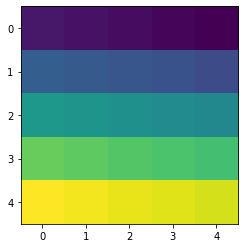

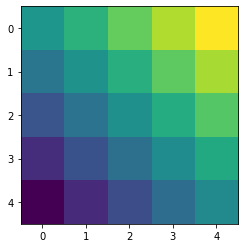

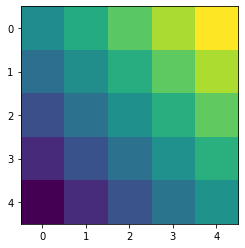

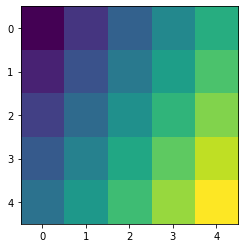

In [64]:
# plot heatmaps for approximated values
def plot_heatmap(value_matrix):
    plt.imshow(value_matrix)
    plt.show()
    
plot_heatmap(df_value_matrix_and)
plot_heatmap(df_value_matrix_nand)
plot_heatmap(df_value_matrix_or)
plot_heatmap(df_value_matrix_xor)

Use the function below to have a 3-D view of the results, passing a list of weights for each gridworld.

In [61]:
def plot_3d(w_list, bool_op_list, world_size, filename="figure.png"):
        #Define the main figure property
        fig, ax_array = plt.subplots(nrows=1, ncols=len(w_list), subplot_kw={'projection': '3d', 'autoscale_on':False})
        #Iteration on all the subplots
        counter = 0
        for ax in ax_array:
            w = w_list[counter]
            print("w: {}".format(w))
            x, y = np.meshgrid(np.arange(0.5, world_size-0.5, 0.5), np.arange(0.5, world_size-0.5, 0.5))
            if w.shape[0] == 3:
                z = w[0]*x + w[1]*y + w[2]
            elif w.shape[0] == 2:
                z = w[0]*x + w[1]*y
            else:
                raise ValueError('[BOOLEAN WORLDS][ERROR] The weight vector has a wrong shape')
            ax.clear()
            #_add_rectangles(ax, bool_op=bool_op_list[counter])
            bool_op = bool_op_list[counter]
            if bool_op == 'AND':
                color_00 = "red"; color_11 = "green"; color_10 = "red"; color_01 = "red"
            elif bool_op == 'NAND':
                color_00 = "green"; color_11 = "red"; color_10 = "green"; color_01 = "green"
            elif bool_op == 'OR':
                color_00 = "red"; color_11 = "green"; color_10 = "green"; color_01 = "green"
            elif bool_op == 'XOR':
                color_00 = "red"; color_11 = "red"; color_10 = "green"; color_01 = "green"
            else:
                color_00 = "red"; color_11 = "red"; color_10 = "red"; color_01 = "red"
            #Draw the rectangles
            p = Rectangle((0, 0), 1, 1, color=color_00, alpha=0.5)
            ax.add_patch(p)
            art3d.pathpatch_2d_to_3d(p, z=-1.0, zdir="z")
            p = Rectangle((world_size-1, world_size-1), 1, 1, color=color_11, alpha=0.5)
            ax.add_patch(p)
            art3d.pathpatch_2d_to_3d(p, z=-1.0, zdir="z")
            p = Rectangle((0, world_size-1), 1, 1, color=color_01, alpha=0.5)
            ax.add_patch(p)
            art3d.pathpatch_2d_to_3d(p, z=-1.0, zdir="z")
            p = Rectangle((world_size-1, 0), 1, 1, color=color_10, alpha=0.5)
            ax.add_patch(p)
            art3d.pathpatch_2d_to_3d(p, z=-1.0, zdir="z")
            #Set the subplot properties
            #ax.tick_params(labelsize=10)
            ax.set_xticks(np.arange(0, world_size+1, 1))
            ax.set_xticklabels('', fontsize=10)
            ax.set_yticklabels('', fontsize=10)
            ax.set_yticks(np.arange(0, world_size+1, 1))
            ax.set_zlim(-1.0,1.0)
            ax.set_zticklabels(['-1.0','','0','','1.0'], fontsize=8)
            ax.view_init(elev=30, azim=-115)
            ax.plot_surface(x,y,z, color='lightgrey', alpha=0.5)
            #Draw a White background
            x, y = np.meshgrid(np.arange(0, world_size+1, 1), np.arange(0, world_size+1, 1))
            z = x*(-1.0)
            ax.plot_surface(x,y,z, color='white', alpha=0.01)
            counter += 1

        fig.savefig(filename, dpi=300) #, bbox_inches='tight')

Generating plot, please wait...
w: [-0.01 -0.  ]
w: [0.02 0.01]
w: [0.08 0.08]
w: [-0.    0.01]


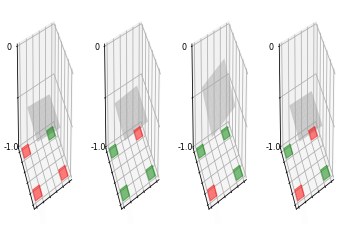

In [62]:
print("Generating plot, please wait...")
plot_3d([w_and, w_nand, w_or, w_xor], ["AND", "NAND", "OR", "XOR"], world_size=5, filename="boolean_planes.png")    

### What is Broken?
You should have noticed that something is broken about the results above. <br/>
Apparently, the supervised linear approximation is not doing a good job creating the planes that separates the positive from the negative rewards for the four gridworlds.

The values should be -1 in proximity of a red cell, and +1 in proximity of a green cell. However, examining the plot we can notice that something strange is happening. The planes are flat and the resulting approximated values is always close to zero in all the worlds but the OR-world. Overall, it seems that the approximator is not working at all and that its output is always null. 
### What is going on? 
Our current definition of approximator does not take into account an important factor, the translation of the plane. Having only two weights we can rotate the surface on the xy-plane but we cannot translate it up and down. Only in the OR-world it is possible to adjust the inclination and satisfy all the constraints.

### How do we Fix it?
We have to introduce the **bias unit**. <br/>
The bias unit, that you may be familiar with if you know regression and neural network models, can be represented as an additional input which is always equal to 1. <br/>
Using the bias unit the input vector becomes x = { x<sub>1</sub>,x<sub>2</sub>, ..., x<sub>N</sub>, x<sub>b</sub>}, with x<sub>b</sub> = 1. <br/>
At the same time we have to add an additional value in the weight vector w = { w<sub>1</sub>,w<sub>2</sub>, ..., w<sub>N</sub>, w<sub>b</sub>}. The additional weight w<sub>b</sub> is updated similarly to the others.

## Question 4
Modify your model to incorporate this bias term and see if it fixes the problem. <br/>

Follow the steps below:

1. Change the **environment initialization functions** below, that you have used for questions 1, 2 and 3, to receive a Boolean parameter indicating if you are using or not the bias term. Basically, you need to change the second return value to incorporate the additional dimension related to the bias term into the array returned for each observation. 
2. Change the **approximation function** for question 2 to receive a boolean parameter indicating if you are using or not the bias term, call the initialization function passing this parameter. Name it **approximation_function_with_bias**. Basically, you will only need to change the return values for **reset** and **step** functions that you are using from the Gridworld environment, to incorporate the new dimension for the returned coordinates of each observation.  

To confirm if your model has solved the issue:
1. Run the approximation function for all Boolean gridworld
2. Plot the approximated values heatmaps for each Boolean gridworld to see if the bias term solved the problem.
3. Use the 3D-plot function below to have a graphical view of the value function related to the 2D grid. <br/>

**Did the bias term solved the problem observed in the previous question?**

In [75]:
def init_and(bias=True):
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[-1.0, 0.0, 0.0, 0.0, 1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [-1.0, 0.0, 0.0, 0.0, -1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    if bias:
        observation = np.random.uniform(-1, 1, 3)
    else:
        observation = np.random.uniform(-1, 1, 2)
    return env, observation

def init_nand(bias=True):
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[1.0, 0.0, 0.0, 0.0, -1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    if bias:
        observation = np.random.uniform(-1, 1, 3)
    else:
        observation = np.random.uniform(-1, 1, 2)
    return env, observation

def init_or(bias=True):
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [-1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    if bias:
        observation = np.random.uniform(-1, 1, 3)
    else:
        observation = np.random.uniform(-1, 1, 2)
    return env, observation

def init_xor(bias=True):
    '''Init the boolean environment

    @return the environment gridworld object
    '''
    env = GridWorld(5, 5)
    #Define the state matrix
    state_matrix = np.array([[1.0, 0.0, 0.0, 0.0, 1.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the index matrix
    index_matrix = np.array([[(4,0), (4,1), (4,2), (4,3), (4,4)],
                             [(3,0), (3,1), (3,2), (3,3), (3,4)],
                             [(2,0), (2,1), (2,2), (2,3), (2,4)],
                             [(1,0), (1,1), (1,2), (1,3), (1,4)],
                             [(0,0), (0,1), (0,2), (0,3), (0,4)]])
    #Define the reward matrix
    reward_matrix = np.array([[1.0, 0.0, 0.0, 0.0, -1.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [-1.0, 0.0, 0.0, 0.0, 1.0]])
    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])
    env.setStateMatrix(state_matrix)
    env.setIndexMatrix(index_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)
    
    if bias:
        observation = np.random.uniform(-1, 1, 3)
    else:
        observation = np.random.uniform(-1, 1, 2)
    return env, observation

In [73]:
def approximation_function_with_bias(world = "AND", gamma = 0.9, alpha_start = 0.001, alpha_stop = 0.000001, 
                           tot_epoch = 30000, use_bias = True):
    """Iterativelly update the weights applying SGD
    Args:
        @param world: the bollean world to use (ANN, NAND, OR, XOR)
        @param gamma:  discaount factor
        @param alpha_start: alpha initial value
        @param alpha_stop: alpha final value
        @param tot_epoch: number of epochs to run
        @param use_bias: boolean indicanting the use of the bias term
    Returns:
        @return mse: Mean Squared Error
        @return w: linear weights
        
    """
    if world == 'AND':
        env, w = init_and(use_bias)
    elif world == 'NAND':
        env, w = init_nand(use_bias)
    elif world == 'OR':
        env, w = init_or(use_bias)
    elif world == 'XOR':
        env, w = init_xor(use_bias)

    
    alpha = alpha_start
    alpha_delta = (alpha_stop - alpha_start) / tot_epoch
    for epoch in range(tot_epoch):
        x = env.reset(exploring_starts=True)
        x = np.append(x, 1)
        action = np.random.choice(4) # use random policy
        x_t1, reward, done = env.step(action)
        x_t1 = np.append(x_t1, 1)
        
        # Update weight using SGD
        w = SGDupdate(w, x, x_t1, reward, alpha, gamma, done)
        # Update alpha with delta per epoch
        alpha += alpha_delta
        
    target_value_matrix = env.reward_matrix
    proximate_value_matrix = get_value_matrix(w, env.world_row, env.world_col)
    mse = mean_squared_error(target_value_matrix, proximate_value_matrix)

    return mse, w

In [76]:
###############################
### RUN YOUR FUNCTION HERE  ###
###############################
world = "AND"
mse_and, w_and = approximation_function_with_bias(world, use_bias = True)
world = "NAND"
mse_nand, w_nand = approximation_function_with_bias(world, use_bias = True)
world = "OR"
mse_or, w_or = approximation_function_with_bias(world, use_bias = True)
world = "XOR"
mse_xor, w_xor = approximation_function_with_bias(world, use_bias = True)

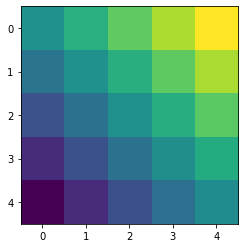

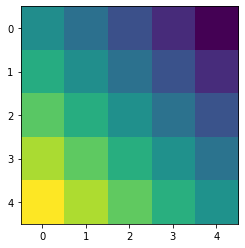

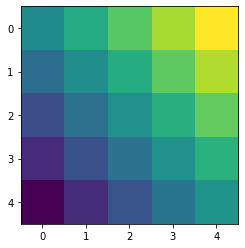

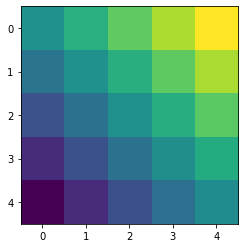

In [77]:
# plot heatmaps for value functions with bias
df_value_matrix_and = print_value_function(w_and, tot_rows=5, tot_cols=5)
df_value_matrix_nand = print_value_function(w_nand, tot_rows=5, tot_cols=5)
df_value_matrix_or = print_value_function(w_or, tot_rows=5, tot_cols=5)
df_value_matrix_xor = print_value_function(w_xor, tot_rows=5, tot_cols=5)

plot_heatmap(df_value_matrix_and)
plot_heatmap(df_value_matrix_nand)
plot_heatmap(df_value_matrix_or)
plot_heatmap(df_value_matrix_xor)

Generating plot, please wait...
w: [ 0.05  0.05 -0.34]
w: [-0.12 -0.11  0.7 ]
w: [0.06 0.07 0.08]
w: [ 0.03  0.03 -0.16]


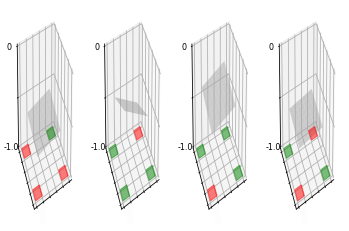

In [78]:
print("Generating plot, please wait...")
plot_3d([w_and, w_nand, w_or, w_xor], ["AND", "NAND", "OR", "XOR"], world_size=5, filename="boolean_planes.png")    

## Question 4 Solution
### Why it worked?
The planes are no more flat, because introducing the bias gave us the possibility to shift them up and down. Now the planes can be adjusted to fit all the constraints. <br/>
For this reason, the matrix has been vertically flipped in order to match the values with the cells of the gridworld. Giving a look to the utilities we can see that in most of the worlds they are pretty good.<br/>
At this point it should be clear why having a function approximator is a big deal. With the lookup table approach we could represent the approximated values of the Boolean worlds using a table with 5 rows and 5 columns, for a total of 25 variables to keep in memory. Now we only need two weights and a bias, for a total of 3 variables. Everything seems fine, we have an approximator which works pretty well and is easy to tune. <br/>
However, our problems are not finished.


### What is Broken?
You may have observed that the **bias term** worked well separating the positive from the negative reward for the AND, NAND and OR gridworlds, except for the XOR gridworld.
### What is going on?
For the XOR-world the plane is still flat. This problem is much serious than the previous one and there is no way to solve it keeping the plane flat. There is no plane that can separate red and green cells in the XOR-world.<br/>
**The XOR-world is not linearly separable!**
### How do we fix it?
The only chance we have to approximate a value function for the XOR-world is to literally bend the plane, and to do it we have to use a higher order approximator.
The linear approximator is the simplest form of approximation. The linear case is appealing not only for its simplicity but also because it is guaranteed to converge. However, there is an important limit implicit in the linear model: it cannot represent complex relationships between features.<br/>
Such a complex interaction naturally arises in physical systems. Some features may be informative only when other features are absent. For example, the inverted pendulum angular position and velocity are tightly connected. A high angular velocity may be either good or bad depending on the position of the pole. If the angle is high then high angular velocity means an imminent danger of falling, whereas if the angle is low then high angular velocity means the pole is righting itself.

Solving the XOR problem is very easy when an additional feature is added.

## Question 5
Change the last approximation function that you've created (approximation_function_with_bias), adding an additional higher order feature by multiplying the two previous used: **x<sub>1</sub>** and **x<sub>2</sub>**. 
Basically, you will need to:
+ Set the parameter **use_bias** = True 
+ Change the coordinates of each observation array returned by the **env.step** function, to incorporate one more dimension: the **x<sub>1</sub>** and **x<sub>2</sub>** new feature.
**Note:** remember that you have already incorporated the bias term in this array for the previous question. Keep it there.

To confirm if your model has solved the issue:
1. Run the approximation function for the **XOR** gridworld
2. Plot the approximated values heatmaps for the XOR gridworld to see if the bias term solved the problem.
3. Use the 3D-plot function below to have a graphical view of the value function related to the 2D grid. <br/>

**Did the higher order term solved the problem observed in the previous question?**

In [81]:
def approximation_function_high_order(world = "XOR", gamma = 0.9, alpha_start = 0.001, alpha_stop = 0.000001, 
                           tot_epoch = 30000, use_bias = True):
    """Iterativelly update the weights applying SGD
    Args:
        @param world: the bollean world to use (ANN, NAND, OR, XOR)
        @param gamma:  discaount factor
        @param alpha_start: alpha initial value
        @param alpha_stop: alpha final value
        @param tot_epoch: number of epochs to run
        @param use_bias: boolean indicanting the use of the bias term
    Returns:
        @return mse: Mean Squared Error
        @return w: linear weights
        
    """
    if world == 'AND':
        env, w = init_and(use_bias)
    elif world == 'NAND':
        env, w = init_nand(use_bias)
    elif world == 'OR':
        env, w = init_or(use_bias)
    elif world == 'XOR':
        env, w = init_xor(use_bias)

    w = np.random.uniform(-1, 1, 4)
    alpha = alpha_start
    alpha_delta = (alpha_stop - alpha_start) / tot_epoch
    for epoch in range(tot_epoch):
        x = env.reset(exploring_starts=True)
        x = np.append(x, x[0] * x[1])
        x = np.append(x, 1)
        action = np.random.choice(4) # use random policy
        x_t1, reward, done = env.step(action)
        x_t1 = np.append(x_t1, x_t1[0] * x_t1[1])
        x_t1 = np.append(x_t1, 1)
        
        # Update weight using SGD
        w = SGDupdate(w, x, x_t1, reward, alpha, gamma, done)
        # Update alpha with delta per epoch
        alpha += alpha_delta
        
    target_value_matrix = env.reward_matrix
    proximate_value_matrix = get_value_matrix(w, env.world_row, env.world_col)
    mse = mean_squared_error(target_value_matrix, proximate_value_matrix)
    
    return mse, w

In [82]:
###############################
### RUN YOUR FUNCTION HERE  ###
###############################
mse_xor, w_quadratic = approximation_function_high_order(world = "XOR")

Use the function below to print the value function returned by your approximation function for the XOR grigworld with the higher oredr term.

In [83]:
def print_value_function_xor(w, tot_rows, tot_cols, decimal=2):
    '''Print on terminal the approximated value matrix of a discrete state space
       having states defined by tuples: (0,0); (0,1); (0,2) ...

    @param w the weights vector
    @param tot_rows total number of rows
    @param tot_cols total number of columns
    @param decimal is the precision of the printing (default: 2 decimal places)
    @param flip boolean which defines if vertical flip is applied (default: True)
    '''
    value_matrix = np.zeros((tot_rows, tot_cols))
    for row in range(tot_rows):
        for col in range(tot_cols):
            x = np.ones(w.shape[0])
            x[0] = row
            x[1] = col
            x[2] = row * col
            x[3] = 1.0
            value_matrix[row,col] = np.dot(x,w)
    np.set_printoptions(precision=decimal) #set print precision of numpy
    
    np.set_printoptions(precision=8) #reset to default
    
    return pd.DataFrame(np.flipud(value_matrix))

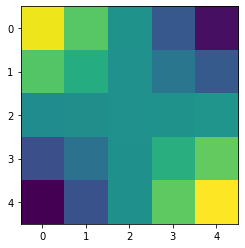

In [84]:
# plot heatmaps for value functions with higher order term
df_value_matrix_xor = print_value_function_xor(w_quadratic, tot_rows=5, tot_cols=5)

plot_heatmap(df_value_matrix_xor)

In [90]:
import lib_rl.xor_paraboloid_td as xor
print("Generating plot, please wait...")
xor.subplot(w_quadratic, world_size=5, filename="xor_planes.png")
print("Done!")

Generating plot, please wait...


NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

<Figure size 432x288 with 0 Axes>